In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics._plot import confusion_matrix as cm
from sklearn.metrics import confusion_matrix
import faiss
from sklearn.utils import resample, shuffle

## Utils

In [2]:
def imageSet(dirActive):
    def getCv2ImgAtIndex(index, labelsCsv):
        ts = labelsCsv['timestamp'][index]
        if not os.path.exists(f'{dirActive}/images/img_{ts}.jpeg'):
             return np.array([])
        img = cv2.resize(cv2.imread(f'{dirActive}/images/img_{ts}.jpeg'),(80,60))
        return img
    labelsCsv = pd.read_csv(f'{dirActive}/labels.csv')
    labelsThatExists = [i for i in range(len(labelsCsv)) if os.path.exists(f'{dirActive}/images/img_{labelsCsv["timestamp"][i]}.jpeg') and labelsCsv['forward/backward'][i] == 1]
    imageArray = np.array([getCv2ImgAtIndex(i,labelsCsv) for i in labelsThatExists])
    leftRightArray = np.array([labelsCsv['left/right'][i] for i in labelsThatExists])
    return imageArray, leftRightArray, labelsCsv

def processedImageSet(imageSet, labelSet, processFunc):
    imageArray = np.array([processFunc(i) for i in imageSet])
    flatImageArray = np.array([image.flatten() for image in imageArray])
    return flatImageArray, labelSet, imageArray, imageSet

def bmxr(im, x=1.5):
    b = im[:,:,0]
    r = im[:,:,2]
    return cv2.subtract(b,cv2.multiply(r,x))

def thresholdIm(im, low=50, high=255):
    e,im = cv2.threshold(im, low, high, cv2.THRESH_BINARY)
    return im

def dispIm(im, label="pic"):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.title(label)
    plt.show()

def dispGSIm(im, label='pic'):
    plt.imshow(im, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
    plt.title(label)
    plt.show()

## Get train and test set

In [3]:
train_u_images, train_u_labels, labelsCsv_train = imageSet('../data/train_data/dataTrackV2_4/')
test_images, test_labels, labelsCsv_test = imageSet('../data/test_data/dataTrackV2_5/')

## Balance the sampling in the training set

## @joe, make sure SHIFT_COUNT=0 when doing model validations.

In [18]:
SHIFT_COUNT = 0
SHIFT_PX = 33

In [19]:
counts = np.bincount(train_u_labels + 1)
print(counts)
dominantClass = 0
dominantClassCount = counts[dominantClass + 1]
print(f'dominant class ({dominantClass}) has {dominantClassCount} samples.')
dominantIndices = np.where(train_u_labels == dominantClass)[0]
X_straight = train_u_images[dominantIndices]
y_straight = train_u_labels[dominantIndices]

X_straight_to_shift = shuffle(X_straight,random_state=42)[:SHIFT_COUNT]

M_left = np.float32([
    [1, 0, -SHIFT_PX],
    [0, 1, 0]
])
X_left_shifted = np.array([cv2.warpAffine(straight, M_left, (straight.shape[1], straight.shape[0])) for straight in X_straight_to_shift])
y_left_shifted = np.ones(SHIFT_COUNT, dtype = int) - 2

M_right = np.float32([
    [1, 0, SHIFT_PX],
    [0, 1, 0]
])
X_right_shifted = np.array([cv2.warpAffine(straight, M_right, (straight.shape[1], straight.shape[0])) for straight in X_straight_to_shift])
y_right_shifted = np.ones(SHIFT_COUNT, dtype = int)

X_left, y_left = resample(train_u_images[train_u_labels == -1], train_u_labels[train_u_labels == -1],
                                 replace=True,     # sample with replacement
                                 n_samples=dominantClassCount-SHIFT_COUNT,    # to match majority class
                                 random_state=42) # reproducible results

X_right, y_right = resample(train_u_images[train_u_labels == 1], train_u_labels[train_u_labels == 1],
                                 replace=True,     # sample with replacement
                                 n_samples=dominantClassCount-SHIFT_COUNT,    # to match majority class
                                 random_state=42) # reproducible results

if SHIFT_COUNT > 0:
    train_labels = np.concatenate((y_left,y_straight,y_right,y_left_shifted,y_right_shifted))
    train_images = np.concatenate((X_left, X_straight, X_right,X_left_shifted,X_right_shifted))
else:
    train_labels = np.concatenate((y_left,y_straight,y_right))
    train_images = np.concatenate((X_left, X_straight, X_right))
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
counts = np.bincount(train_labels + 1)
print(counts)

[ 2158 13609  1547]
dominant class (0) has 13609 samples.
[13609 13609 13609]


## Process the data

In [20]:
def processImage(im):    
    im = bmxr(im,1.25)
    im = thresholdIm(im,8,255)
    
    return im

X_test, y_test, X_test_images, X_test_originals = processedImageSet(test_images, test_labels, processImage)
X_train, y_train, X_train_images, X_train_originals = processedImageSet(train_images, train_labels, processImage)

In [21]:
import random

def displayRandom(ims, originals, k=5):
    for i in range(k):
        ind = random.randint(0, len(ims))
        dispIm(originals[ind],f'og @{ind}')
        dispIm(ims[ind], f'edit @{ind}')

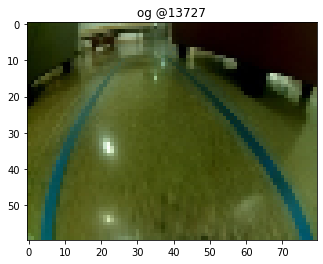

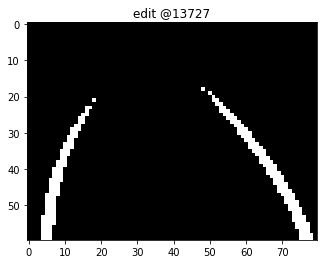

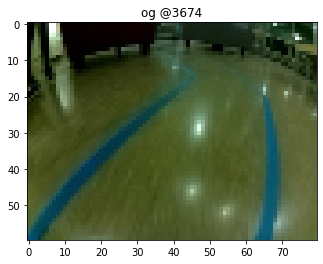

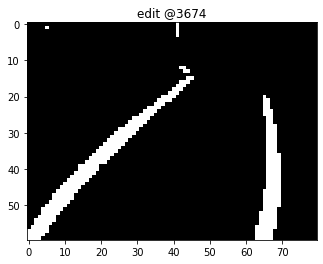

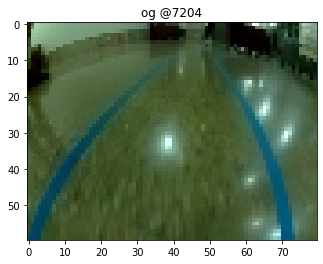

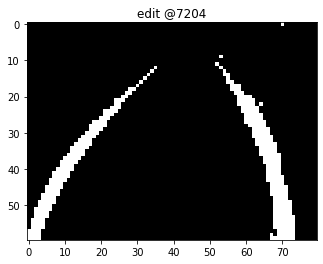

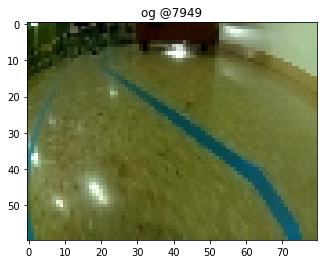

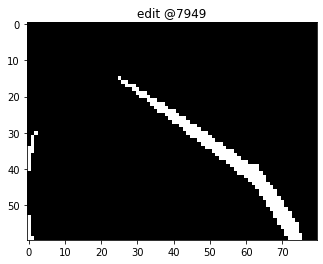

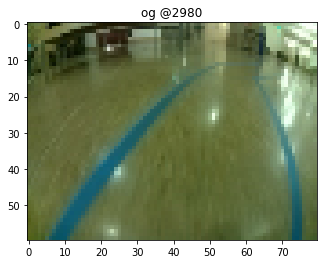

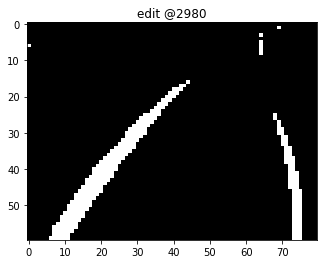

In [22]:
# displayRandom(X_test_images, X_test_originals)
displayRandom(X_train_images, X_train_originals)

# K-NearestNeighbours

In [23]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices] + 1
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes]) - 1
        return predictions

In [24]:
def runKNN(k):
    knn = FaissKNeighbors(k=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    bacc = balanced_accuracy_score(y_test, y_predict)
    print(f'k={k} test accuracy: {acc:.3f} bacc: {bacc:.3f}')
    matrix = confusion_matrix(y_test, y_predict)
    disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
    disp.plot(include_values=True, cmap=plt.cm.Blues);

k=20 test accuracy: 0.712 bacc: 0.712


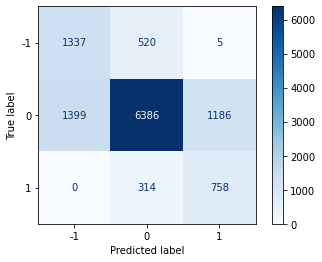

In [143]:
runKNN(21)

In [ ]:
runKNN(51)

In [ ]:
runKNN(121)

# Keras

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [26]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
from keras import backend as K
K.clear_session()
history1 = None
model = None

In [28]:
model = keras.Sequential(
    [
        keras.Input(shape=(4800,)),
        layers.Dropout(.4),
        layers.Dense(32, activation="relu", name="layer54"),
        layers.Dropout(.4),
        layers.Dense(64, activation="relu", name="layer55"),
        layers.Dense(3, name="layer6", activation="softmax"),
    ]
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 4800)              0         
_________________________________________________________________
layer54 (Dense)              (None, 32)                153632    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
layer55 (Dense)              (None, 64)                2112      
_________________________________________________________________
layer6 (Dense)               (None, 3)                 195       
Total params: 155,939
Trainable params: 155,939
Non-trainable params: 0
_________________________________________________________________


In [30]:
# loss_fn = keras.losses.categorical_crossentropy()
# opt = keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

In [31]:
# Call model on a test input
y = model(X_test)
y

<tf.Tensor: shape=(11905, 3), dtype=float32, numpy=
array([[2.2312273e-14, 1.0000000e+00, 0.0000000e+00],
       [7.0582465e-23, 1.0000000e+00, 0.0000000e+00],
       [7.5080627e-12, 1.0000000e+00, 0.0000000e+00],
       ...,
       [9.9997938e-01, 2.0611311e-05, 0.0000000e+00],
       [9.9997938e-01, 2.0611311e-05, 0.0000000e+00],
       [9.9997938e-01, 2.0611311e-05, 0.0000000e+00]], dtype=float32)>

In [32]:
from sklearn.preprocessing import OneHotEncoder
esc = OneHotEncoder()
esc.fit(np.array([-1,0,1]).reshape(-1, 1))
y_train_os = esc.transform(y_train.reshape(-1,1)).toarray()
y_test_os = esc.transform(y_test.reshape(-1,1)).toarray()
# es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto',patience=10)

In [33]:
n_epochs = 1
history1 = model.fit((X_train / 255), y_train_os, validation_split=0.1, batch_size=16, epochs=n_epochs, verbose=1)

2297/2297 [==============================] - 6s 2ms/step - loss: 0.4831 - accuracy: 0.7981 - mse: 0.0973 - val_loss: 0.3159 - val_accuracy: 0.8699 - val_mse: 0.0637


test accuracy: 0.884 bacc: 0.884


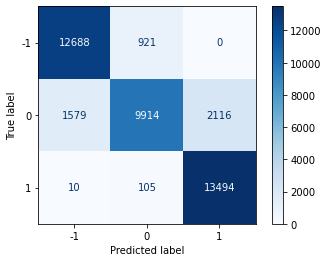

In [34]:
y_train_pred_out = model.predict(X_train/255)
y_train_pred = np.array([raw.argmax() - 1 for raw in y_train_pred_out])
acc = accuracy_score(y_train, y_train_pred)
bacc = balanced_accuracy_score(y_train, y_train_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_train, y_train_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

test accuracy: 0.711 bacc: 0.778


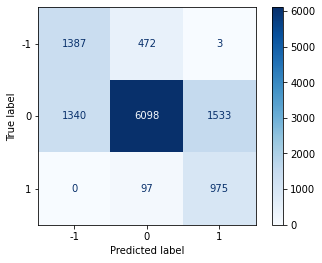

In [35]:
y_test_pred_out = model.predict(X_test/255)
y_test_pred = np.array([raw.argmax() - 1 for raw in y_test_pred_out])
acc = accuracy_score(y_test, y_test_pred)
bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_test, y_test_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

pred
1
true
0


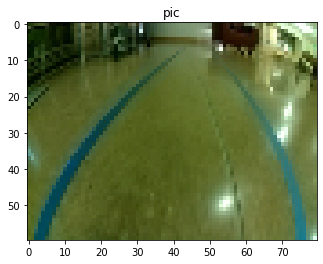

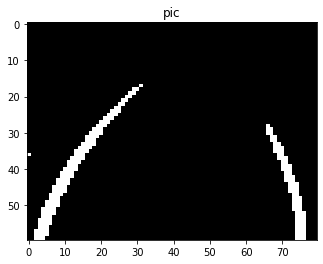

In [36]:
errors = np.where(y_test_pred != y_test)[0]
i = np.random.choice(errors)
print("pred")
print(y_test_pred[i])
print('true')
print(y_test[i])
dispIm(X_test_originals[i])
dispIm(X_test_images[i])

In [48]:
model.save('../models/daniel_dense_new_v69.h5')

# CNN

In [74]:
K.clear_session()
history2 = None
model2 = None

In [38]:
model2 = keras.Sequential()
model2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((3, 3)))
model2.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2, 2)))
model2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(keras.layers.Flatten())
model2.add(layers.Dropout(.4))
model2.add(keras.layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(.4))
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

In [39]:
# model2.summary()

In [40]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

In [42]:
X_train_images.shape

(40827, 60, 80)

In [43]:
n_epochs = 1
X_t = X_train_images.reshape(-1,60,80,1)
history2 = model2.fit((X_t / 255), y_train_os, validation_split=0.1, batch_size=16, epochs=n_epochs, verbose=1)

2297/2297 [==============================] - 9s 3ms/step - loss: 0.4498 - accuracy: 0.8124 - mse: 0.0920 - val_loss: 0.3433 - val_accuracy: 0.8482 - val_mse: 0.0721


[[2.4868734e-02 9.7440255e-01 7.2882243e-04]
 [3.9533254e-02 9.6013540e-01 3.3139848e-04]
 [2.9867692e-02 9.6964496e-01 4.8730263e-04]
 ...
 [7.4165225e-01 2.5802681e-01 3.2100984e-04]
 [7.4165225e-01 2.5802681e-01 3.2100984e-04]
 [7.4165225e-01 2.5802681e-01 3.2100984e-04]]
test accuracy: 0.708 bacc: 0.801


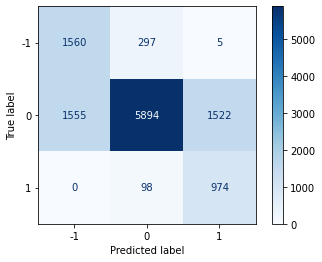

In [44]:
y_test_pred_out = model2.predict(X_test_images.reshape(-1,60,80,1)/255)
print(y_test_pred_out)
y_test_pred = np.array([raw.argmax() - 1 for raw in y_test_pred_out])
acc = accuracy_score(y_test, y_test_pred)
bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_test, y_test_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

In [47]:
model2.save('../models/daniel_cnn_bmxr_v70.h5')